# Detection of wood defects
We start by exploring the train_defect_information.csv file to explore the different types of defects especially in the location of interest

In [1]:
import pandas as pd
defect_data = pd.read_csv("train_defect_information.csv")
defect_data.head()

img_filename    mask_filename  location  contains_label_0  \
0      img_0.jpg      img_0_l.png         0              True   
1      img_1.jpg      img_1_l.png         0              True   
2    img_100.jpg    img_100_l.png         0              True   
3   img_1000.jpg   img_1000_l.png         3              True   
4  img_10000.jpg  img_10000_l.png         3              True   

   contains_label_1  contains_label_2  contains_label_3  contains_label_4  \
0              True             False             False             False   
1             False             False             False             False   
2             False              True             False             False   
3             False             False             False             False   
4              True             False             False             False   

   contains_label_5  contains_label_6  contains_label_7  contains_label_8  \
0             False             False              True             False   
1             False             False              True             False   
2              True             False             False             False   
3             False             False             False             False   
4             False              True             False             False   

   contains_label_9  contains_label_10  
0             False              False  
1             False              False  
2             False              False  
3             False              False  
4             False              False

In [2]:
defect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15160 entries, 0 to 15159
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   img_filename       15160 non-null  object
 1   mask_filename      15160 non-null  object
 2   location           15160 non-null  int64 
 3   contains_label_0   15160 non-null  bool  
 4   contains_label_1   15160 non-null  bool  
 5   contains_label_2   15160 non-null  bool  
 6   contains_label_3   15160 non-null  bool  
 7   contains_label_4   15160 non-null  bool  
 8   contains_label_5   15160 non-null  bool  
 9   contains_label_6   15160 non-null  bool  
 10  contains_label_7   15160 non-null  bool  
 11  contains_label_8   15160 non-null  bool  
 12  contains_label_9   15160 non-null  bool  
 13  contains_label_10  15160 non-null  bool  
dtypes: bool(11), int64(1), object(2)
memory usage: 518.3+ KB


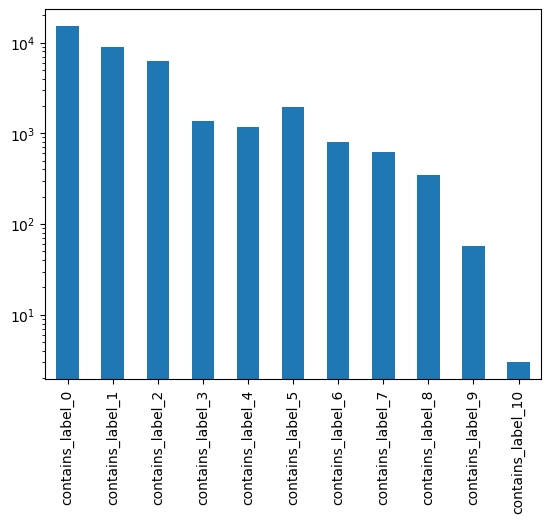

In [3]:
import matplotlib.pyplot as plt

# count the number of True values in each boolean column
bool_cols = defect_data.select_dtypes(include=bool)
true_counts_total = bool_cols.sum()

# create a bar chart of the true_counts Series
true_counts_total.plot(kind='bar')
plt.yscale("log")
plt.show()

We can see that most of the images have no defects and the label 10 has the least occurance in the defects, since the data is imbalanced to train the deep learning model, we calculate some weights that helps the loss function to better classify the data 
- class_weights calculates the weights with an inverse relationship to their occurance
- class_weights_smoothed adds a penalty alpha so that the weighting is not so extreme

I will be using class_weights_smoothed for further weighting the loss function to balance the imbalanced class numbers

In [4]:
class_frequencies = true_counts_total.values
total_pixels = class_frequencies.sum()
class_weights = total_pixels / (class_frequencies + 1e-8) # Add a small constant to avoid division by zero
class_weights = class_weights / class_weights.sum()
class_weights

array([1.83855222e-04, 3.13596441e-04, 4.49628193e-04, 2.05700751e-03,
       2.39043325e-03, 1.41844538e-03, 3.43680046e-03, 4.51010545e-03,
       8.10245689e-03, 4.80559512e-02, 9.29081720e-01])

In [5]:
sum_frequencies = class_frequencies.sum()
alpha = 1e4
smoothed_frequencies = class_frequencies + alpha
class_weights_smoothed = sum_frequencies / smoothed_frequencies
class_weights_smoothed = class_weights_smoothed / class_weights_smoothed.sum()
class_weights_smoothed

array([0.04424199, 0.0589331 , 0.06871587, 0.0980298 , 0.09968909,
       0.09303204, 0.10296258, 0.10483409, 0.10761102, 0.11067095,
       0.11127946])

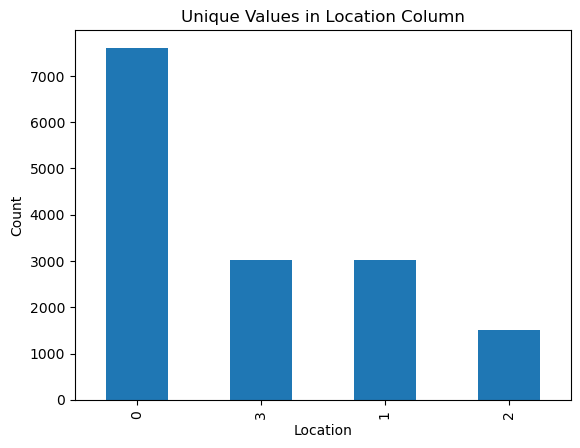

In [6]:
# count unique values in the location column
location_counts = defect_data['location'].value_counts()

# create a bar plot of the location counts
location_counts.plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Unique Values in Location Column')
plt.show()

Most of the images are taken from location 0, but since we are interested in predicting the defects for location 3, then in this attempt we use the data from all locations to train our model and then evaluate the results for location 3 samples

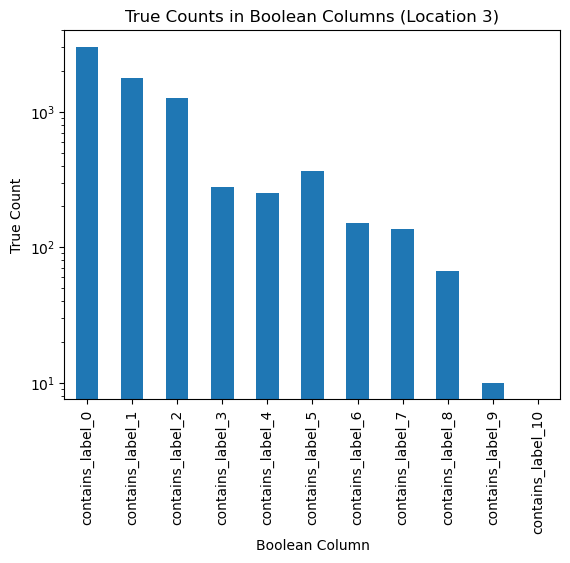

In [7]:
# select rows where location is 3
location_3_df = defect_data[defect_data['location'] == 3]

# count true values in boolean columns
true_counts_location3 = location_3_df.select_dtypes(include=bool).sum()

# create a bar plot of the true counts
true_counts_location3.plot(kind='bar')
plt.xlabel('Boolean Column')
plt.ylabel('True Count')
plt.title('True Counts in Boolean Columns (Location 3)')
plt.yscale("log")
plt.show()

In [8]:
true_counts_location3

contains_label_0     3024
contains_label_1     1777
contains_label_2     1256
contains_label_3      278
contains_label_4      250
contains_label_5      367
contains_label_6      152
contains_label_7      137
contains_label_8       67
contains_label_9       10
contains_label_10       0
dtype: int64

Since we are interested in location 3 images , we check the number of labels for location 3, and we see that there is no defect with the 10th label so for this location later on we can opt it out of the training - work in progress (not yet implemented)

In [9]:
import os
import torch
import time
import random
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
import torchvision.transforms.functional as TF
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import torchvision

- since most but not all images are 612*224 we resize the images for this resolution
- we set the test split on 10 percent of the images of the training set for model validation
- current GPU memory (Nvidia A6000) maxes out on a batch size of 20
- the trained model and a plot of training and validation error is saved in a folder called output

In [10]:
# define the path to the images and masks dataset
image_dataset_path = "train_input"
mask_dataset_path = "train_labels"

# define the test split
test_split = 0.10

# determine the device to be used for training and evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.backends.cudnn.benchmark = True

#initialize learning rate, number of epochs to train for, and the batch size
init_lr = 1e-4
num_epochs = 100
batch_size = 20

# define the input image dimensions
input_image_width = 612
input_image_height = 224

# define the path to the base output directory
base_output = "output"
if not os.path.exists(base_output):
    os.makedirs(base_output)

# define the path to the output serialized model, model training plot, and testing image paths
model_path = os.path.join(base_output, "unet_model.pth")
plot_path = os.path.sep.join([base_output, "plot.png"])
test_paths = os.path.sep.join([base_output, "test_paths.txt"])

In [22]:
# load the image and mask filepaths in a sorted manner
imagePaths = defect_data.img_filename
maskPaths = defect_data.mask_filename
imageprefix = image_dataset_path + "\\"
maskprefix = mask_dataset_path + "\\"
imagePaths = [imageprefix + x for x in imagePaths]
maskPaths = [maskprefix + x for x in maskPaths]
# partition the data into training and testing splits using test_split
split = train_test_split(imagePaths, maskPaths, test_size=test_split, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(test_paths, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


checking the images added in the path list

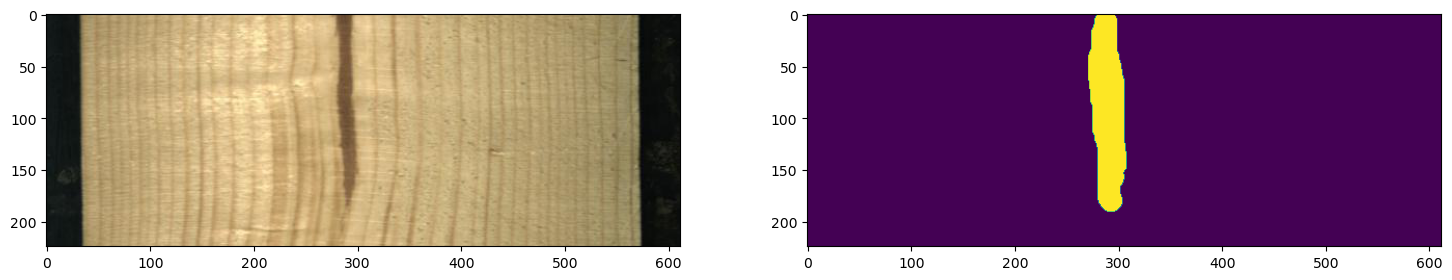

In [23]:
# view images
index = 1
fig , ax =  plt.subplots(1, 2, figsize=(18, 9))
ax[0].imshow(Image.open(imagePaths[index]))
ax[1].imshow(Image.open(maskPaths[index]))

The dataset is loaded by:
- coverting the input images to RGB
- fixing a seed for transforms to input images and labels in case we need data augmentation (not implemented yet)
- resize all images to dimensions defined before
- we transform the pixel values of the label images to integer values between 0 and 10
- normalize the pixel values of the input images to floats between 0 and 1 (ToTensor transform does this)
- transform the output lables to 2 dimensional images (with squeeze)

In [24]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        img_path = self.imagePaths[idx]
        mask_path = self.maskPaths[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        
        if self.transforms is not None:
            # we set random seeds so that the same augmentation is applied to both the image and the mask
            seed = np.random.randint(2147483647)
            random.seed(seed)
            torch.manual_seed(seed)
            transformed_image = self.transforms(image)

            random.seed(seed)
            torch.manual_seed(seed)
            transformed_mask = self.transforms(mask)

            mask_tensor = transformed_mask.squeeze(0)
            
            # Scale mask tensor values to the range [0, 10] and convert to long datatype
            mask_tensor = (mask_tensor * 1000).long()
            mask_tensor = torch.clamp(mask_tensor, 0, 10)

            return (transformed_image, mask_tensor)

        # If no transformations are applied, we need to convert the image and mask to tensors
        image_tensor = transforms.ToTensor()(image)
        mask_tensor = transforms.ToTensor()(mask).squeeze(0)
        
        # Scale mask tensor values to the range [0, 10] and convert to long datatype
        mask_tensor = (mask_tensor * 1000).long()
        mask_tensor = torch.clamp(mask_tensor, 0, 10)

        return (image_tensor, mask_tensor)

In [25]:
# define transformations (!for now no augmentation applied)
transforms_ = transforms.Compose([
    transforms.Resize((input_image_height, input_image_width)),
    transforms.ToTensor()
])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms_)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms_)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size, pin_memory = True if device == "cuda" else False)
testLoader = DataLoader(testDS, shuffle=False, batch_size=batch_size, pin_memory= True if device == "cuda" else False)

[INFO] found 13644 examples in the training set...
[INFO] found 1516 examples in the test set...


In [26]:
# Run this to test your data loader
(images, masks) = next(iter(trainLoader))

double check if the output and input sizes and values are correct

In [27]:
print(f'woodboards(x) = shape: {images.shape}; type: {images.dtype}')
print(f'segmentation masks(y) = shape: {masks.shape}; type: {masks.dtype}')
print(f'woodboards(x) = min: {images.min()}; max: {images.max()}')
print(f'segmentation masks(y) = min: {masks.min()}; max: {masks.max()}')

woodboards(x) = shape: torch.Size([20, 3, 224, 612]); type: torch.float32
segmentation masks(y) = shape: torch.Size([20, 224, 612]); type: torch.int64
woodboards(x) = min: 0.0; max: 1.0
segmentation masks(y) = min: 0; max: 10


check the input images and output labels visually and the corresponding histograms

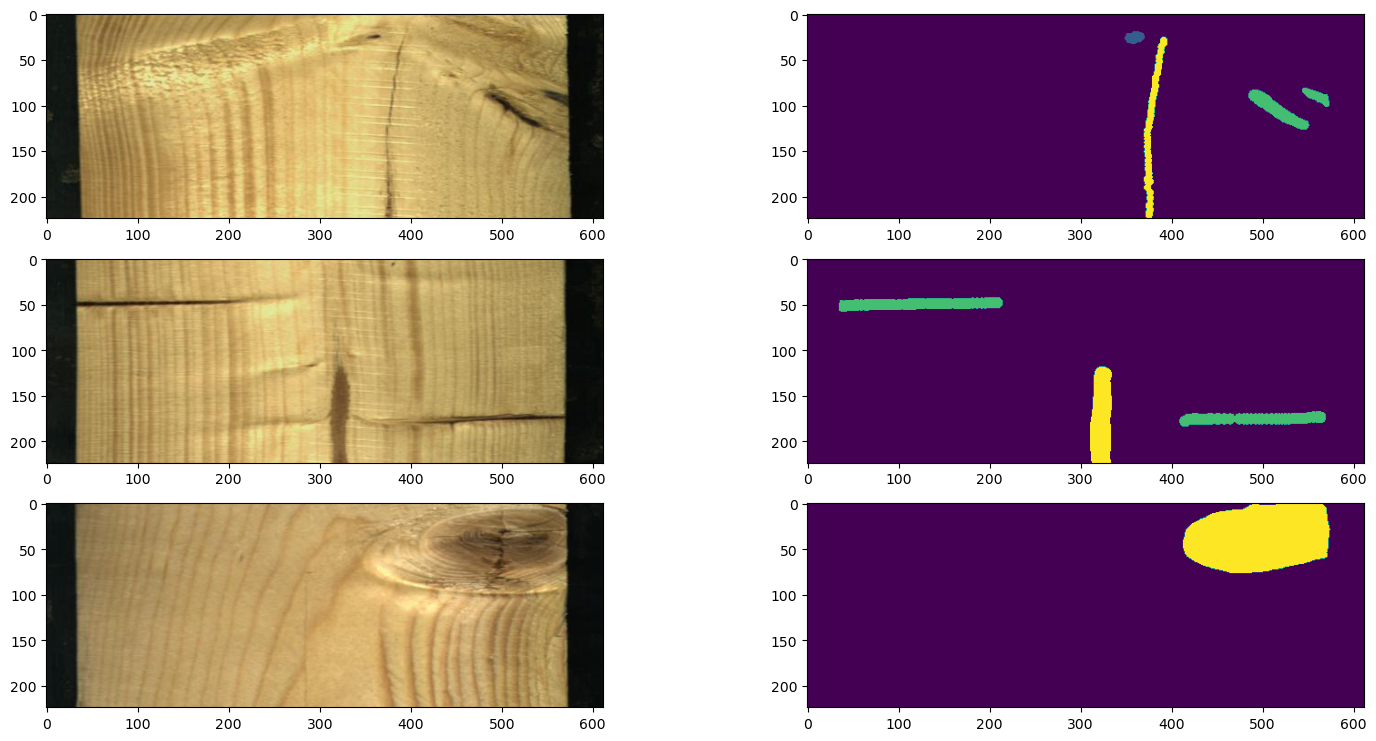

In [28]:
# plot three example images to show
img1 = images[0,:,:,:].numpy().transpose((1, 2, 0))
mask1 = masks[0,:,:,].numpy()
img2 = images[1,:,:,:].numpy().transpose((1, 2, 0))
mask2 = masks[1,:,:,].numpy()
img3 = images[2,:,:,:].numpy().transpose((1, 2, 0))
mask3 = masks[2,:,:,].numpy()
fig , ax =  plt.subplots(3, 2, figsize=(18, 9))
ax[0][0].imshow(img1)
ax[0][1].imshow(mask1)
ax[1][0].imshow(img2)
ax[1][1].imshow(mask2)
ax[2][0].imshow(img3)
ax[2][1].imshow(mask3)

In [29]:
def plot_hist(image):
    hist = image.histc()
    images_min = image.min().item()
    images_max = image.max().item()
    plt.plot(torch.linspace(images_min, images_max, len(hist)), hist)
    plt.show()
def plot_bar(image):
    hist = image.histc()
    images_min = image.min().item()
    images_max = image.max().item()
    plt.bar(torch.linspace(images_min, images_max, len(hist)), hist)
    plt.yscale("log")
    plt.show()

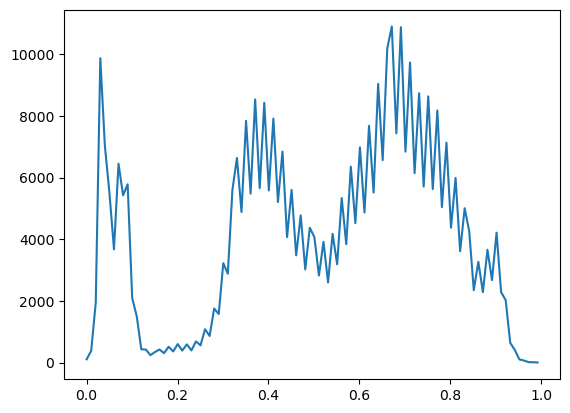

In [30]:
plot_hist(images[1])

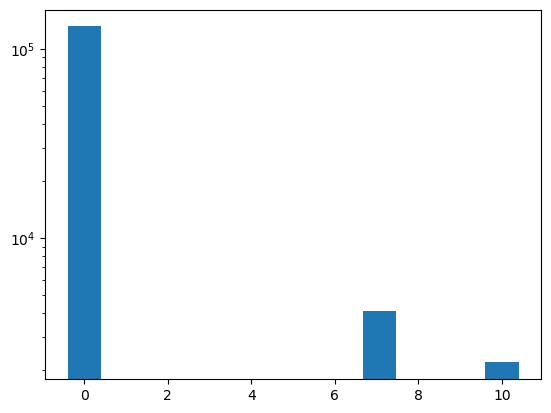

In [31]:
plot_bar(masks[1].float())

We define a Unet architecture here with flexible features and flexible input image dimensions (normally unet is limited to dimensions that can be divided by 16)

In [32]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # make sure the input is dividable by 16
        
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            # to solve the problem of input not dividable by 16
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

- we input RGB images therefore we have 3 input channels and there are 11 labels to predict therefore there are 11 output channels for the UNet
- we use the weights calculated before from the number of labels in the dataset here in a cross entropy loss function and we use Adam optimizer

In [33]:
# initialize our UNet model
unet = UNet(in_channels=3, out_channels=11).to(device)
# initialize loss function and optimizer
class_weights_tensor = torch.tensor(class_weights_smoothed, dtype=torch.float).to(device)
lossFunc = CrossEntropyLoss(weight=class_weights_tensor)
opt = Adam(unet.parameters(), lr=init_lr)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

double check the input and output functionally of the model with random initial weights

In [34]:
output = unet(images.to(device))

In [35]:
loss = lossFunc(output, masks.to(device).long())
print(loss)

tensor(2.8362, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


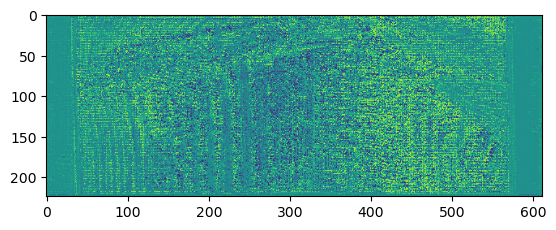

In [36]:
# Apply softmax to convert raw output values to probabilities
probabilities = F.softmax(output, dim=1)
# Apply argmax to get the index of the highest probability class for each pixel
predicted_masks = torch.argmax(probabilities, dim=1).to('cpu')
preds1 = np.array(predicted_masks[0])
plt.imshow(preds1)

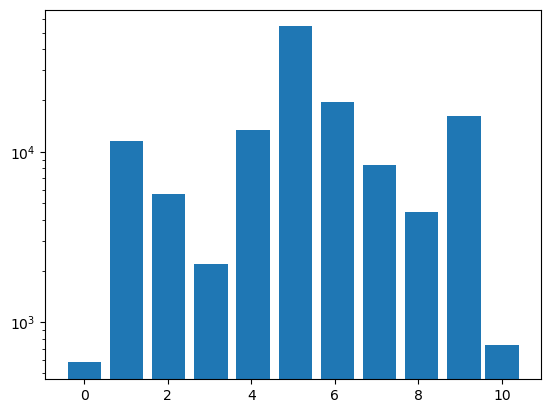

In [37]:
plot_bar(predicted_masks[0].float())

Since the functionality of the model is verified we can start the training with the 100 epochs defined from before

[INFO] training the network...


  1%|▊                                                                             | 1/100 [06:06<10:05:22, 366.89s/it]

[INFO] EPOCH: 1/100
Train loss: 1.013561, Test loss: 0.3949


  2%|█▌                                                                             | 2/100 [12:02<9:48:39, 360.41s/it]

[INFO] EPOCH: 2/100
Train loss: 0.218264, Test loss: 0.1297


  3%|██▎                                                                            | 3/100 [17:58<9:38:50, 358.05s/it]

[INFO] EPOCH: 3/100
Train loss: 0.094233, Test loss: 0.0726


  4%|███▏                                                                           | 4/100 [23:57<9:33:49, 358.64s/it]

[INFO] EPOCH: 4/100
Train loss: 0.063287, Test loss: 0.0536


  5%|███▉                                                                           | 5/100 [29:53<9:26:16, 357.65s/it]

[INFO] EPOCH: 5/100
Train loss: 0.051337, Test loss: 0.0481


  6%|████▋                                                                          | 6/100 [35:48<9:19:06, 356.88s/it]

[INFO] EPOCH: 6/100
Train loss: 0.045077, Test loss: 0.0435


  7%|█████▌                                                                         | 7/100 [41:44<9:12:41, 356.57s/it]

[INFO] EPOCH: 7/100
Train loss: 0.041304, Test loss: 0.0386


  8%|██████▎                                                                        | 8/100 [47:40<9:06:12, 356.23s/it]

[INFO] EPOCH: 8/100
Train loss: 0.038642, Test loss: 0.0443


  9%|███████                                                                        | 9/100 [53:36<9:00:05, 356.10s/it]

[INFO] EPOCH: 9/100
Train loss: 0.036403, Test loss: 0.0367


 10%|███████▊                                                                      | 10/100 [59:32<8:54:07, 356.08s/it]

[INFO] EPOCH: 10/100
Train loss: 0.034797, Test loss: 0.0362


 11%|████████▎                                                                   | 11/100 [1:05:27<8:47:58, 355.94s/it]

[INFO] EPOCH: 11/100
Train loss: 0.033539, Test loss: 0.0369


 12%|█████████                                                                   | 12/100 [1:11:23<8:41:55, 355.86s/it]

[INFO] EPOCH: 12/100
Train loss: 0.032012, Test loss: 0.0356


 13%|█████████▉                                                                  | 13/100 [1:17:19<8:35:52, 355.78s/it]

[INFO] EPOCH: 13/100
Train loss: 0.030441, Test loss: 0.0335


 14%|██████████▋                                                                 | 14/100 [1:23:14<8:29:53, 355.74s/it]

[INFO] EPOCH: 14/100
Train loss: 0.029274, Test loss: 0.0341


 15%|███████████▍                                                                | 15/100 [1:29:10<8:24:06, 355.85s/it]

[INFO] EPOCH: 15/100
Train loss: 0.028139, Test loss: 0.0347


 16%|████████████▏                                                               | 16/100 [1:35:06<8:18:01, 355.73s/it]

[INFO] EPOCH: 16/100
Train loss: 0.027002, Test loss: 0.0331


 17%|████████████▉                                                               | 17/100 [1:41:01<8:12:00, 355.67s/it]

[INFO] EPOCH: 17/100
Train loss: 0.025370, Test loss: 0.0340


 18%|█████████████▋                                                              | 18/100 [1:46:57<8:05:57, 355.58s/it]

[INFO] EPOCH: 18/100
Train loss: 0.024656, Test loss: 0.0335


 19%|██████████████▍                                                             | 19/100 [1:52:53<8:00:21, 355.82s/it]

[INFO] EPOCH: 19/100
Train loss: 0.022918, Test loss: 0.0363


 20%|███████████████▏                                                            | 20/100 [1:58:49<7:54:35, 355.94s/it]

[INFO] EPOCH: 20/100
Train loss: 0.022332, Test loss: 0.0350


 21%|███████████████▉                                                            | 21/100 [2:04:45<7:48:26, 355.78s/it]

[INFO] EPOCH: 21/100
Train loss: 0.021325, Test loss: 0.0359


 22%|████████████████▋                                                           | 22/100 [2:10:40<7:42:21, 355.66s/it]

[INFO] EPOCH: 22/100
Train loss: 0.019843, Test loss: 0.0371


 23%|█████████████████▍                                                          | 23/100 [2:16:36<7:36:34, 355.77s/it]

[INFO] EPOCH: 23/100
Train loss: 0.018921, Test loss: 0.0407


 24%|██████████████████▏                                                         | 24/100 [2:22:32<7:30:32, 355.69s/it]

[INFO] EPOCH: 24/100
Train loss: 0.021813, Test loss: 0.0377


 25%|███████████████████                                                         | 25/100 [2:28:28<7:25:00, 356.00s/it]

[INFO] EPOCH: 25/100
Train loss: 0.017740, Test loss: 0.0392


 26%|███████████████████▊                                                        | 26/100 [2:34:24<7:18:58, 355.92s/it]

[INFO] EPOCH: 26/100
Train loss: 0.016898, Test loss: 0.0397


 27%|████████████████████▌                                                       | 27/100 [2:40:20<7:12:58, 355.86s/it]

[INFO] EPOCH: 27/100
Train loss: 0.016649, Test loss: 0.0439


 28%|█████████████████████▎                                                      | 28/100 [2:46:15<7:06:56, 355.78s/it]

[INFO] EPOCH: 28/100
Train loss: 0.018394, Test loss: 0.0431


 29%|██████████████████████                                                      | 29/100 [2:52:11<7:00:59, 355.76s/it]

[INFO] EPOCH: 29/100
Train loss: 0.015555, Test loss: 0.0439


 30%|██████████████████████▊                                                     | 30/100 [2:58:08<6:55:19, 355.99s/it]

[INFO] EPOCH: 30/100
Train loss: 0.015280, Test loss: 0.0449


 31%|███████████████████████▌                                                    | 31/100 [3:04:03<6:49:11, 355.82s/it]

[INFO] EPOCH: 31/100
Train loss: 0.014211, Test loss: 0.0445


 32%|████████████████████████▎                                                   | 32/100 [3:09:58<6:43:02, 355.62s/it]

[INFO] EPOCH: 32/100
Train loss: 0.014193, Test loss: 0.0481


 33%|█████████████████████████                                                   | 33/100 [3:15:54<6:37:12, 355.71s/it]

[INFO] EPOCH: 33/100
Train loss: 0.013421, Test loss: 0.0444


 34%|█████████████████████████▊                                                  | 34/100 [3:21:50<6:31:12, 355.64s/it]

[INFO] EPOCH: 34/100
Train loss: 0.014759, Test loss: 0.0457


 35%|██████████████████████████▌                                                 | 35/100 [3:27:46<6:25:24, 355.76s/it]

[INFO] EPOCH: 35/100
Train loss: 0.012910, Test loss: 0.0471


 36%|███████████████████████████▎                                                | 36/100 [3:33:41<6:19:24, 355.69s/it]

[INFO] EPOCH: 36/100
Train loss: 0.012236, Test loss: 0.0498


 37%|████████████████████████████                                                | 37/100 [3:39:37<6:13:24, 355.63s/it]

[INFO] EPOCH: 37/100
Train loss: 0.012499, Test loss: 0.0432


 38%|████████████████████████████▉                                               | 38/100 [3:45:33<6:07:38, 355.79s/it]

[INFO] EPOCH: 38/100
Train loss: 0.013017, Test loss: 0.0497


 39%|█████████████████████████████▋                                              | 39/100 [3:51:28<6:01:40, 355.75s/it]

[INFO] EPOCH: 39/100
Train loss: 0.011531, Test loss: 0.0553


 40%|██████████████████████████████▍                                             | 40/100 [3:57:26<5:56:23, 356.40s/it]

[INFO] EPOCH: 40/100
Train loss: 0.011034, Test loss: 0.0474


 41%|███████████████████████████████▏                                            | 41/100 [4:03:22<5:50:08, 356.08s/it]

[INFO] EPOCH: 41/100
Train loss: 0.012641, Test loss: 0.0515


 42%|███████████████████████████████▉                                            | 42/100 [4:09:17<5:44:03, 355.92s/it]

[INFO] EPOCH: 42/100
Train loss: 0.010811, Test loss: 0.0558


 43%|████████████████████████████████▋                                           | 43/100 [4:15:13<5:38:06, 355.90s/it]

[INFO] EPOCH: 43/100
Train loss: 0.010251, Test loss: 0.0550


 44%|█████████████████████████████████▍                                          | 44/100 [4:21:09<5:32:04, 355.79s/it]

[INFO] EPOCH: 44/100
Train loss: 0.011265, Test loss: 0.0498


 45%|██████████████████████████████████▏                                         | 45/100 [4:27:06<5:26:31, 356.21s/it]

[INFO] EPOCH: 45/100
Train loss: 0.009478, Test loss: 0.0611


 46%|██████████████████████████████████▉                                         | 46/100 [4:33:01<5:20:25, 356.04s/it]

[INFO] EPOCH: 46/100
Train loss: 0.008982, Test loss: 0.0594


 47%|███████████████████████████████████▋                                        | 47/100 [4:38:57<5:14:23, 355.92s/it]

[INFO] EPOCH: 47/100
Train loss: 0.011525, Test loss: 0.0471


 48%|████████████████████████████████████▍                                       | 48/100 [4:44:53<5:08:32, 356.01s/it]

[INFO] EPOCH: 48/100
Train loss: 0.009925, Test loss: 0.0553


 49%|█████████████████████████████████████▏                                      | 49/100 [4:50:49<5:02:29, 355.87s/it]

[INFO] EPOCH: 49/100
Train loss: 0.009357, Test loss: 0.0489


 50%|██████████████████████████████████████                                      | 50/100 [4:56:46<4:56:55, 356.31s/it]

[INFO] EPOCH: 50/100
Train loss: 0.009497, Test loss: 0.0541


 51%|██████████████████████████████████████▊                                     | 51/100 [5:02:43<4:51:04, 356.41s/it]

[INFO] EPOCH: 51/100
Train loss: 0.009101, Test loss: 0.0559


 52%|███████████████████████████████████████▌                                    | 52/100 [5:08:39<4:44:57, 356.19s/it]

[INFO] EPOCH: 52/100
Train loss: 0.007936, Test loss: 0.0640


 53%|████████████████████████████████████████▎                                   | 53/100 [5:14:35<4:39:03, 356.25s/it]

[INFO] EPOCH: 53/100
Train loss: 0.007323, Test loss: 0.0626


 54%|█████████████████████████████████████████                                   | 54/100 [5:20:31<4:32:59, 356.07s/it]

[INFO] EPOCH: 54/100
Train loss: 0.007273, Test loss: 0.0643


 55%|█████████████████████████████████████████▊                                  | 55/100 [5:26:26<4:26:53, 355.86s/it]

[INFO] EPOCH: 55/100
Train loss: 0.009736, Test loss: 0.0529


 56%|██████████████████████████████████████████▌                                 | 56/100 [5:32:25<4:21:38, 356.78s/it]

[INFO] EPOCH: 56/100
Train loss: 0.009461, Test loss: 0.0595


 57%|███████████████████████████████████████████▎                                | 57/100 [5:38:20<4:15:23, 356.36s/it]

[INFO] EPOCH: 57/100
Train loss: 0.006816, Test loss: 0.0633


 58%|████████████████████████████████████████████                                | 58/100 [5:44:16<4:09:24, 356.31s/it]

[INFO] EPOCH: 58/100
Train loss: 0.008162, Test loss: 0.0643


 59%|████████████████████████████████████████████▊                               | 59/100 [5:50:12<4:03:17, 356.04s/it]

[INFO] EPOCH: 59/100
Train loss: 0.007387, Test loss: 0.0485


 60%|█████████████████████████████████████████████▌                              | 60/100 [5:56:07<3:57:15, 355.88s/it]

[INFO] EPOCH: 60/100
Train loss: 0.008102, Test loss: 0.0639


 61%|██████████████████████████████████████████████▎                             | 61/100 [6:02:03<3:51:22, 355.97s/it]

[INFO] EPOCH: 61/100
Train loss: 0.006141, Test loss: 0.0673


 62%|███████████████████████████████████████████████                             | 62/100 [6:07:59<3:45:23, 355.89s/it]

[INFO] EPOCH: 62/100
Train loss: 0.007481, Test loss: 0.0617


 63%|███████████████████████████████████████████████▉                            | 63/100 [6:13:55<3:39:31, 355.99s/it]

[INFO] EPOCH: 63/100
Train loss: 0.006361, Test loss: 0.0703


 64%|████████████████████████████████████████████████▋                           | 64/100 [6:19:51<3:33:30, 355.85s/it]

[INFO] EPOCH: 64/100
Train loss: 0.005794, Test loss: 0.0611


 65%|█████████████████████████████████████████████████▍                          | 65/100 [6:25:47<3:27:31, 355.77s/it]

[INFO] EPOCH: 65/100
Train loss: 0.008243, Test loss: 0.0670


 66%|██████████████████████████████████████████████████▏                         | 66/100 [6:31:43<3:21:47, 356.10s/it]

[INFO] EPOCH: 66/100
Train loss: 0.005515, Test loss: 0.0736


 67%|██████████████████████████████████████████████████▉                         | 67/100 [6:37:39<3:15:45, 355.93s/it]

[INFO] EPOCH: 67/100
Train loss: 0.005786, Test loss: 0.0719


 68%|███████████████████████████████████████████████████▋                        | 68/100 [6:43:35<3:09:51, 356.00s/it]

[INFO] EPOCH: 68/100
Train loss: 0.005317, Test loss: 0.0704


 69%|████████████████████████████████████████████████████▍                       | 69/100 [6:49:31<3:03:51, 355.84s/it]

[INFO] EPOCH: 69/100
Train loss: 0.005235, Test loss: 0.0701


 70%|█████████████████████████████████████████████████████▏                      | 70/100 [6:55:30<2:58:28, 356.95s/it]

[INFO] EPOCH: 70/100
Train loss: 0.006909, Test loss: 0.0654


 71%|█████████████████████████████████████████████████████▉                      | 71/100 [7:01:27<2:52:32, 356.98s/it]

[INFO] EPOCH: 71/100
Train loss: 0.006088, Test loss: 0.0737


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [7:07:23<2:46:24, 356.57s/it]

[INFO] EPOCH: 72/100
Train loss: 0.004925, Test loss: 0.0747


 73%|███████████████████████████████████████████████████████▍                    | 73/100 [7:13:19<2:40:23, 356.44s/it]

[INFO] EPOCH: 73/100
Train loss: 0.004446, Test loss: 0.0769


 74%|████████████████████████████████████████████████████████▏                   | 74/100 [7:19:14<2:34:20, 356.17s/it]

[INFO] EPOCH: 74/100
Train loss: 0.007003, Test loss: 0.0646


 75%|█████████████████████████████████████████████████████████                   | 75/100 [7:25:10<2:28:19, 355.97s/it]

[INFO] EPOCH: 75/100
Train loss: 0.005059, Test loss: 0.0739


 76%|█████████████████████████████████████████████████████████▊                  | 76/100 [7:31:06<2:22:25, 356.05s/it]

[INFO] EPOCH: 76/100
Train loss: 0.006502, Test loss: 0.0616


 77%|██████████████████████████████████████████████████████████▌                 | 77/100 [7:37:02<2:16:25, 355.88s/it]

[INFO] EPOCH: 77/100
Train loss: 0.004655, Test loss: 0.0738


 78%|███████████████████████████████████████████████████████████▎                | 78/100 [7:42:58<2:10:31, 355.96s/it]

[INFO] EPOCH: 78/100
Train loss: 0.003992, Test loss: 0.0783


 79%|████████████████████████████████████████████████████████████                | 79/100 [7:48:53<2:04:32, 355.82s/it]

[INFO] EPOCH: 79/100
Train loss: 0.003824, Test loss: 0.0771


 80%|████████████████████████████████████████████████████████████▊               | 80/100 [7:54:49<1:58:33, 355.70s/it]

[INFO] EPOCH: 80/100
Train loss: 0.004240, Test loss: 0.0782


 81%|█████████████████████████████████████████████████████████████▌              | 81/100 [8:00:45<1:52:40, 355.80s/it]

[INFO] EPOCH: 81/100
Train loss: 0.005124, Test loss: 0.0530


 82%|██████████████████████████████████████████████████████████████▎             | 82/100 [8:06:40<1:46:43, 355.75s/it]

[INFO] EPOCH: 82/100
Train loss: 0.005895, Test loss: 0.0661


 83%|███████████████████████████████████████████████████████████████             | 83/100 [8:12:37<1:40:50, 355.93s/it]

[INFO] EPOCH: 83/100
Train loss: 0.004037, Test loss: 0.0755


 84%|███████████████████████████████████████████████████████████████▊            | 84/100 [8:18:32<1:34:53, 355.82s/it]

[INFO] EPOCH: 84/100
Train loss: 0.003427, Test loss: 0.0805


 85%|████████████████████████████████████████████████████████████████▌           | 85/100 [8:24:28<1:28:56, 355.78s/it]

[INFO] EPOCH: 85/100
Train loss: 0.003333, Test loss: 0.0829


 86%|█████████████████████████████████████████████████████████████████▎          | 86/100 [8:30:25<1:23:04, 356.04s/it]

[INFO] EPOCH: 86/100
Train loss: 0.005986, Test loss: 0.0567


 87%|██████████████████████████████████████████████████████████████████          | 87/100 [8:36:20<1:17:06, 355.91s/it]

[INFO] EPOCH: 87/100
Train loss: 0.004730, Test loss: 0.0739


 88%|██████████████████████████████████████████████████████████████████▉         | 88/100 [8:42:16<1:11:09, 355.81s/it]

[INFO] EPOCH: 88/100
Train loss: 0.003427, Test loss: 0.0774


 89%|███████████████████████████████████████████████████████████████████▋        | 89/100 [8:48:12<1:05:15, 355.93s/it]

[INFO] EPOCH: 89/100
Train loss: 0.003070, Test loss: 0.0800


 90%|██████████████████████████████████████████████████████████████████████▏       | 90/100 [8:54:08<59:18, 355.83s/it]

[INFO] EPOCH: 90/100
Train loss: 0.004549, Test loss: 0.0598


 91%|██████████████████████████████████████████████████████████████████████▉       | 91/100 [9:00:04<53:25, 356.13s/it]

[INFO] EPOCH: 91/100
Train loss: 0.004225, Test loss: 0.0760


 92%|███████████████████████████████████████████████████████████████████████▊      | 92/100 [9:06:00<47:27, 355.94s/it]

[INFO] EPOCH: 92/100
Train loss: 0.003155, Test loss: 0.0787


 93%|████████████████████████████████████████████████████████████████████████▌     | 93/100 [9:11:56<41:30, 355.83s/it]

[INFO] EPOCH: 93/100
Train loss: 0.002980, Test loss: 0.0825


 94%|█████████████████████████████████████████████████████████████████████████▎    | 94/100 [9:17:51<35:34, 355.78s/it]

[INFO] EPOCH: 94/100
Train loss: 0.003003, Test loss: 0.0825


 95%|██████████████████████████████████████████████████████████████████████████    | 95/100 [9:23:47<29:38, 355.69s/it]

[INFO] EPOCH: 95/100
Train loss: 0.003900, Test loss: 0.0707


 96%|██████████████████████████████████████████████████████████████████████████▉   | 96/100 [9:29:44<23:44, 356.10s/it]

[INFO] EPOCH: 96/100
Train loss: 0.005588, Test loss: 0.0681


 97%|███████████████████████████████████████████████████████████████████████████▋  | 97/100 [9:35:39<17:47, 355.90s/it]

[INFO] EPOCH: 97/100
Train loss: 0.003245, Test loss: 0.0797


 98%|████████████████████████████████████████████████████████████████████████████▍ | 98/100 [9:41:35<11:51, 355.82s/it]

[INFO] EPOCH: 98/100
Train loss: 0.002695, Test loss: 0.0866


 99%|█████████████████████████████████████████████████████████████████████████████▏| 99/100 [9:47:31<05:55, 355.80s/it]

[INFO] EPOCH: 99/100
Train loss: 0.002614, Test loss: 0.0876


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [9:53:26<00:00, 356.07s/it]

[INFO] EPOCH: 100/100
Train loss: 0.002762, Test loss: 0.0851
[INFO] total time taken to train the model: 35606.68s


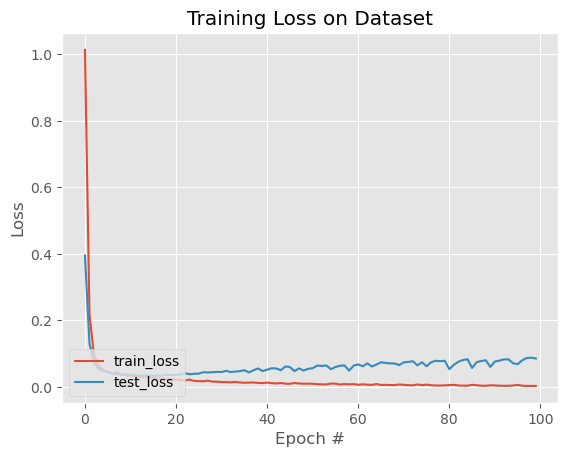

In [38]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y.long())
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y.long())
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk
torch.save(unet, model_path)

From the plot of train loss and test loss we can clearly see that after epoch 20 the train loss is deviating from the test loss, showing an overfit to the training data. Possible solutions to mitigate this are:
- using data augmentations
- adding drop out to the network
- early stop the model

In [39]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(model_path).to(device)

[INFO] load up model...


In [40]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    num_classes = 11
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            # Calculate Dice score for each class
            dice_score_class = torch.zeros(num_classes).to(device)
            for cls in range(num_classes):
                intersection = torch.logical_and(preds == cls, y == cls).sum().float()
                union = (preds == cls).sum().float() + (y == cls).sum().float()
                dice_score_class[cls] += (2 * intersection + 1e-8) / (union + 1e-8)
            
            dice_score += dice_score_class.mean()

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [41]:
# check_accuracy(trainLoader, unet)

on the test data we see a dice score of around 0.92 showing that there is not a good match between the prediction classification and test data classification considering that the defects are small portions of the images

In [42]:
check_accuracy(testLoader, unet)

Got 206587840/207825408 with acc 99.40
Dice score: 0.9189850687980652


Visualizing the predictions on the training data

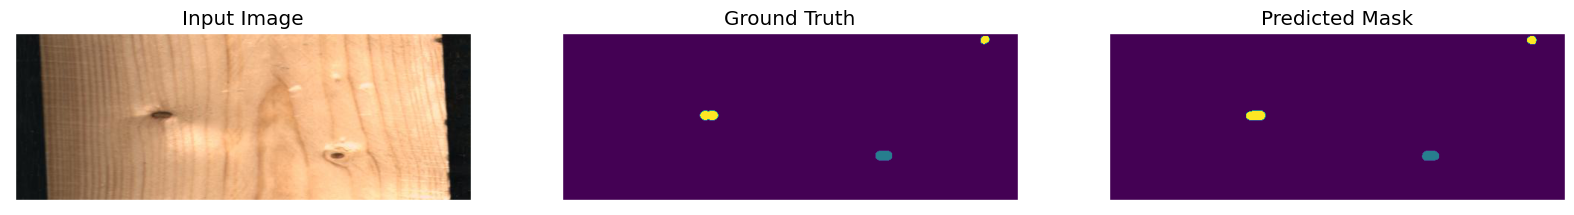

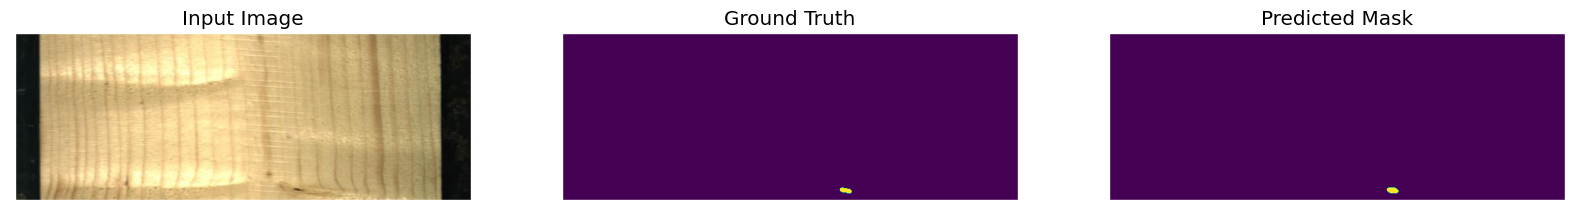

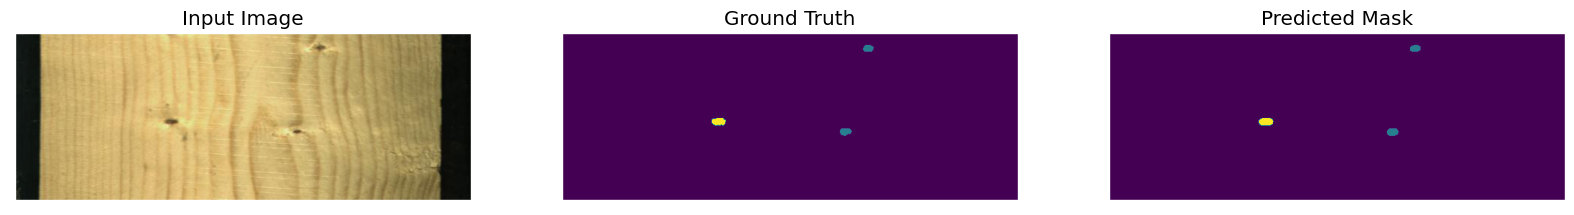

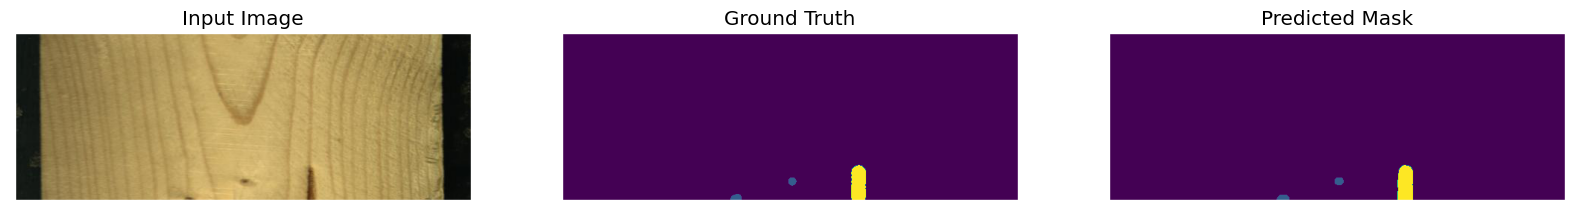

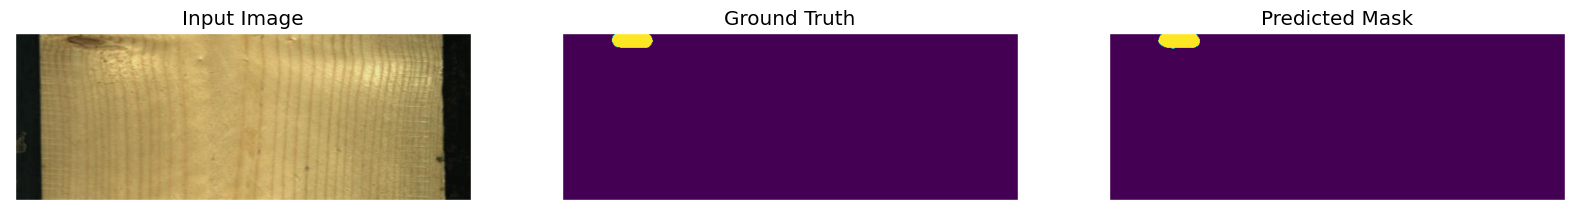

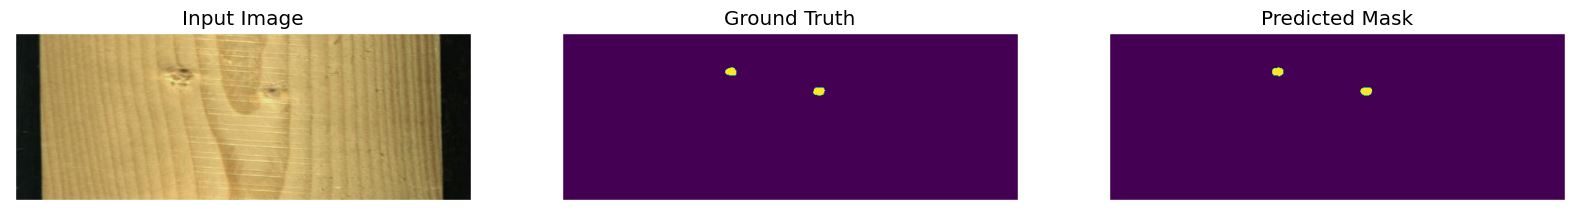

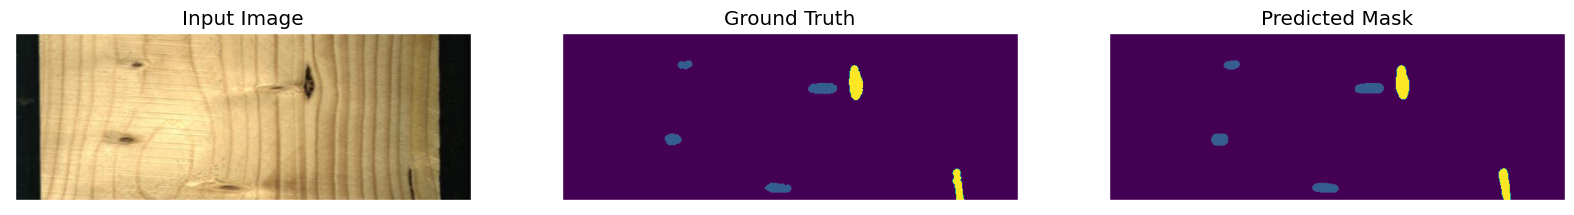

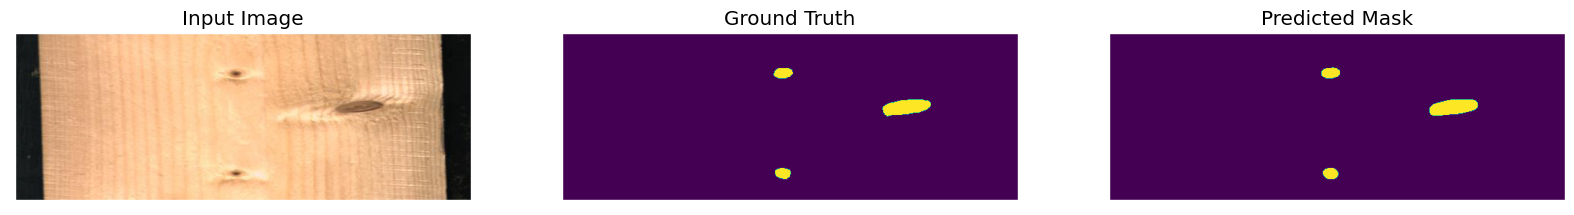

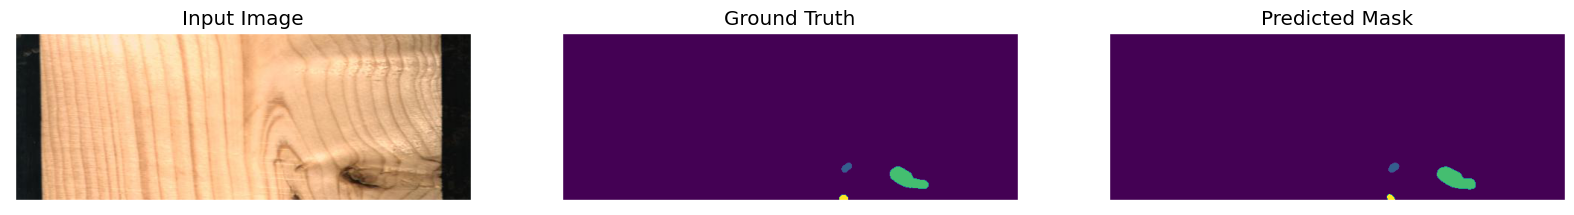

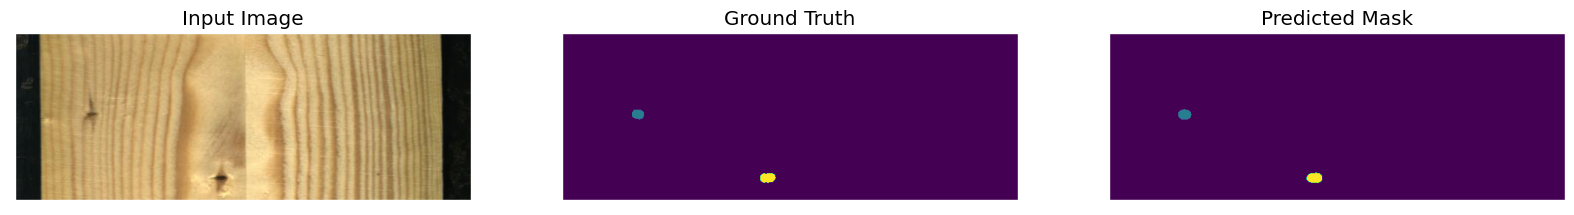

In [43]:
# Number of images to visualize
num_visualizations = 10

# Set the model to evaluation mode
unet.eval()

# Get a batch of train data
train_images, train_labels = next(iter(trainLoader))

# Move the images and labels to the appropriate device
train_images = train_images.to(device)
train_labels = train_labels.to(device)

# Generate predictions
predictions = unet(train_images)

# Apply softmax and argmax to get the predicted class labels
predictions = torch.argmax(torch.softmax(predictions, dim=1), dim=1)

# Move the predictions and labels back to CPU for visualization
predictions = predictions.cpu().numpy()
train_labels = train_labels.cpu().numpy()

# Loop through the visualizations
for i in range(num_visualizations):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # Display the original image
    axes[0].imshow(train_images[i].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Input Image")

    # Display the ground truth mask
    axes[1].imshow(train_labels[i])
    axes[1].set_title("Ground Truth")

    # Display the predicted mask
    axes[2].imshow(predictions[i])
    axes[2].set_title("Predicted Mask")

    # Remove axis ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Show the plots
    plt.show()


Visualize the predictions on the test data

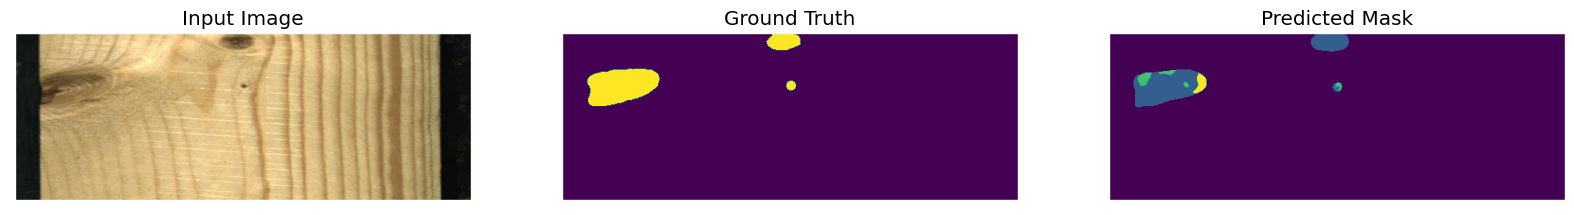

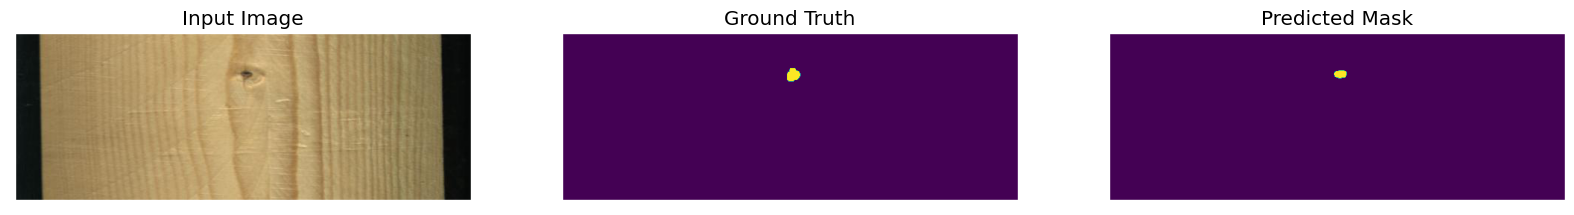

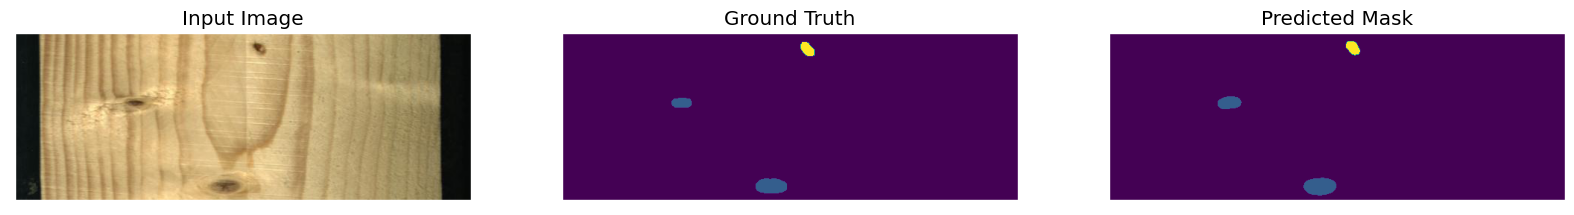

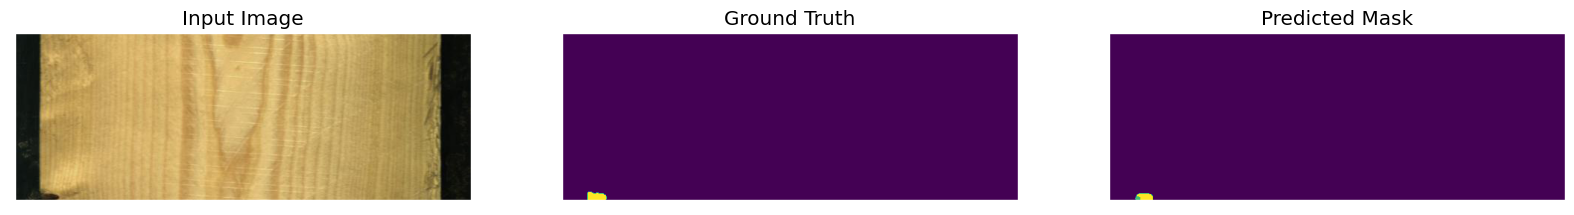

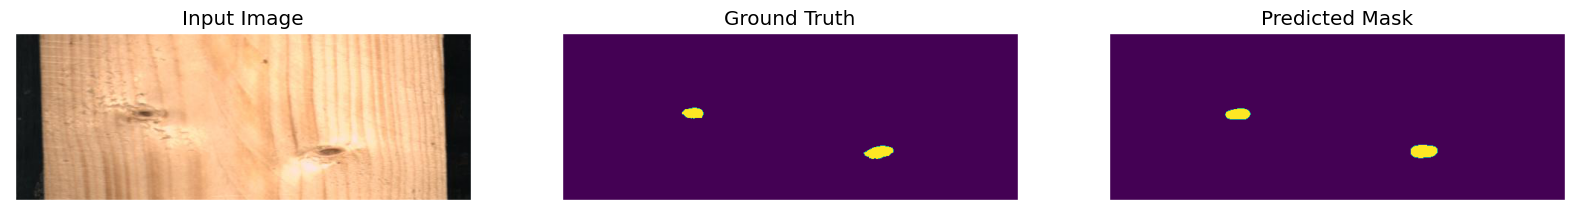

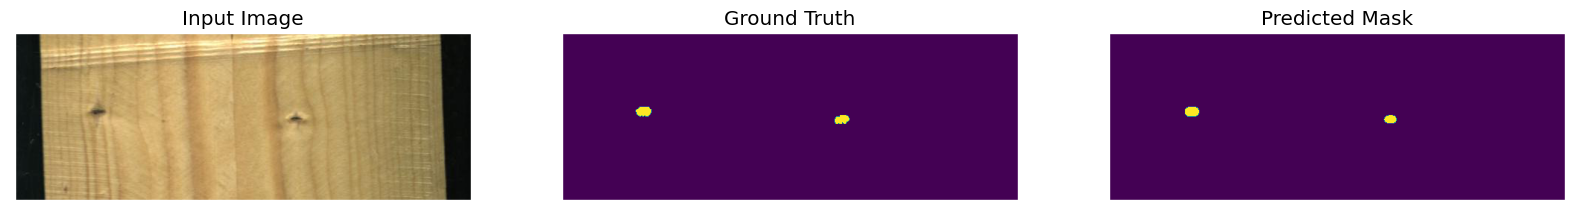

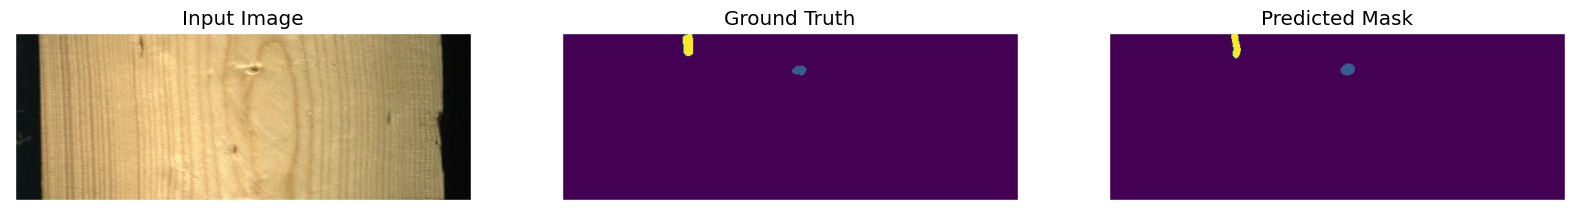

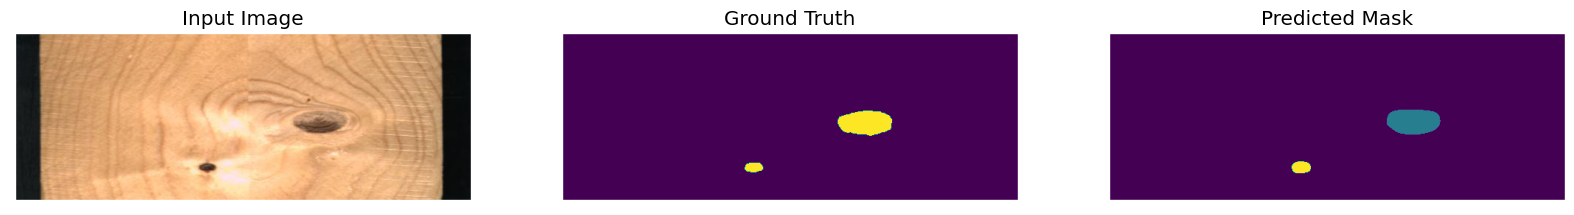

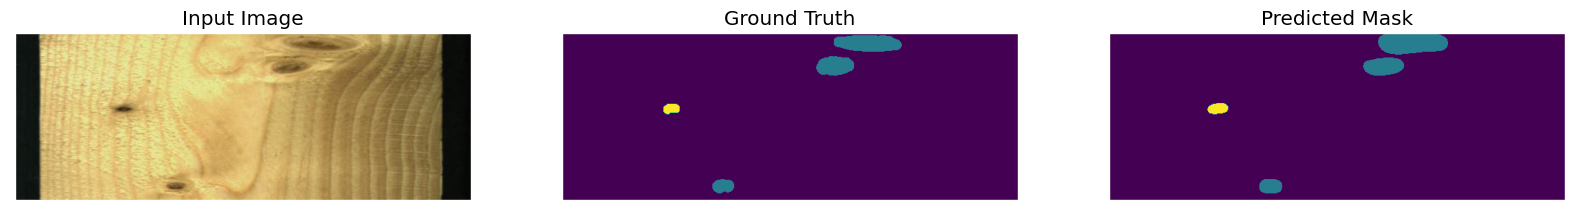

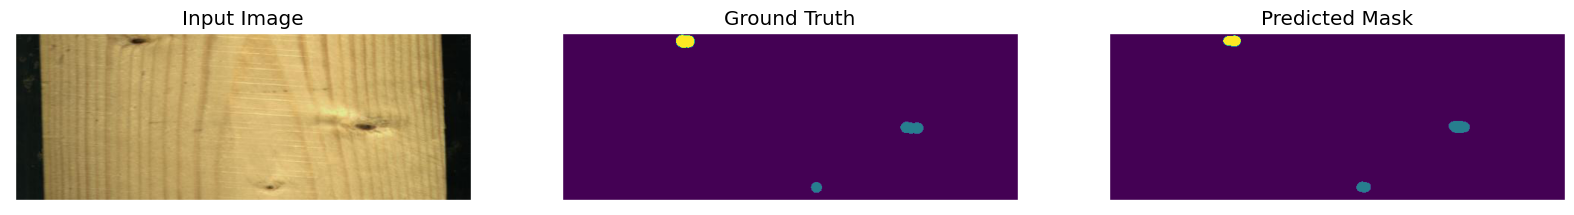

In [44]:
# Number of images to visualize
num_visualizations = 10

# Set the model to evaluation mode
unet.eval()

# Get a batch of test data
test_images, test_labels = next(iter(testLoader))

# Move the images and labels to the appropriate device
test_images = test_images.to(device)
test_labels = test_labels.to(device)

# Generate predictions
predictions = unet(test_images)

# Apply softmax and argmax to get the predicted class labels
predictions = torch.argmax(torch.softmax(predictions, dim=1), dim=1)

# Move the predictions and labels back to CPU for visualization
predictions = predictions.cpu().numpy()
test_labels = test_labels.cpu().numpy()

# Loop through the visualizations
for i in range(num_visualizations):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # Display the original image
    axes[0].imshow(test_images[i].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Input Image")

    # Display the ground truth mask
    axes[1].imshow(test_labels[i])
    axes[1].set_title("Ground Truth")

    # Display the predicted mask
    axes[2].imshow(predictions[i])
    axes[2].set_title("Predicted Mask")

    # Remove axis ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Show the plots
    plt.show()


In [92]:
unet.eval()

# Create the 'test_labels' folder if it doesn't exist
if not os.path.exists('test_labels'):
    os.makedirs('test_labels')

# Define the transformation for the input images
input_transforms = transforms_

# Loop through the images in the 'test_input' folder
for image_name in os.listdir('test_input'):
    # Load and preprocess the image
    image_path = os.path.join('test_input', image_name)
    image = Image.open(image_path).convert('RGB')
    input_tensor = input_transforms(image).unsqueeze(0)  # Add batch dimension

    # Make a prediction using your trained model
    with torch.no_grad():
        output = unet(input_tensor.cuda())
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy() # values between 0 and 10

    # Save the predicted mask as an image in the 'test_labels' folder
    pred_image = Image.fromarray((pred).astype(np.uint8), mode='L') # one channel
    pred_image.save(os.path.join('test_labels', image_name[:-4] + '_l.png')) # -l + png

test_input\img_10043.jpg
test_labels\img_10043_l.png
Make sure numbers are the same!


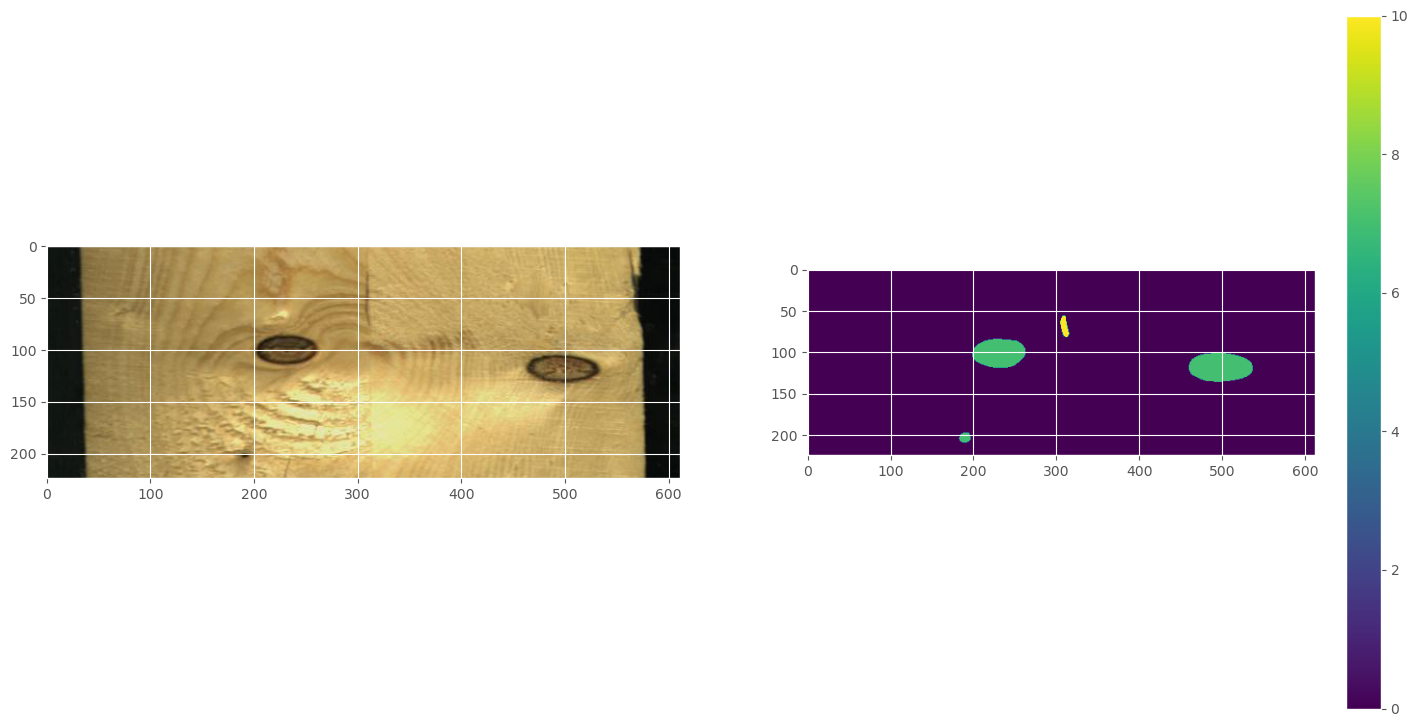

In [107]:
# view images of test labels and test predictions
index = 13
fig , ax =  plt.subplots(1, 2, figsize=(18, 9))
test_input_path = os.path.join('test_input', os.listdir('test_input')[index])
print(test_input_path)
test_labels_path = os.path.join('test_labels', os.listdir('test_labels')[index-1])
print(test_labels_path)
print("Make sure numbers are the same!")
ax[0].imshow(Image.open(test_input_path))
im = ax[1].imshow(Image.open(test_labels_path))
cbar = ax[1].figure.colorbar(im, ax=ax[1])
plt.show()

# Conclusions and remarks
As we can see from the loss plot, dice score and visualizations above the model performs better on training data but not on the test data because of over fitting. Also the performance on the test data can be improved by fixing the overfitting problem.

the predictions of the model for the hold out test set from location 3 are saved in the test_labels folder . I would recommend doing the steps below to improve the model:

- training a model having the test set only from location 3
- trying out different weightingss for the loss function
- try out the points mentioned about mitigations for the overfitting
- try out training a model using only data from location 3
- try out more features for the UNet model or try out different model architectures